In [21]:
import pandas as pd
from PIL import Image
Image.MAX_IMAGE_PIXELS=None
import numpy as np
from skimage.measure import label
from skimage.morphology import closing, square, remove_small_objects, remove_small_holes
from skimage.transform import rotate
from math import atan2, degrees
import glob,os
from natsort import natsorted
from copy import deepcopy
import cv2
from time import time
from skimage.measure import regionprops
from matplotlib import pyplot as plt

In [22]:
src = r'\\fatherserverdw\kyuex\clue images\1um\classification_v9_combined'
imlist = glob.glob(os.path.join(src,'*.tif'))
imlist = natsorted(imlist)
imlist=imlist[0:5]

C:\Users\kyuha\AppData\Local\Temp\ipykernel_12176\2629492986.py:33: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  unknown = cv2.subtract(sure_bg, sure_fg).astype(np.bool)


section N:  1 / 1
52 sec elapsed for part A
5 sec elapsed for part B
0 sec elapsed for part C
0 sec elapsed for part D


C:\Users\kyuha\AppData\Local\Temp\ipykernel_12176\2629492986.py:33: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  unknown = cv2.subtract(sure_bg, sure_fg).astype(np.bool)


section N:  1 / 1
43 sec elapsed for part A
5 sec elapsed for part B
0 sec elapsed for part C
0 sec elapsed for part D


C:\Users\kyuha\AppData\Local\Temp\ipykernel_12176\2629492986.py:33: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  unknown = cv2.subtract(sure_bg, sure_fg).astype(np.bool)


section N:  1 / 1
42 sec elapsed for part A
5 sec elapsed for part B
0 sec elapsed for part C
0 sec elapsed for part D


C:\Users\kyuha\AppData\Local\Temp\ipykernel_12176\2629492986.py:33: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  unknown = cv2.subtract(sure_bg, sure_fg).astype(np.bool)


section N:  1 / 1
47 sec elapsed for part A


KeyboardInterrupt: 

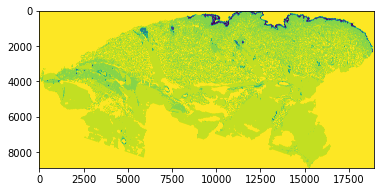

In [23]:
df=[]
for imname in imlist:
    minTA = 20000
    minTAhole = 100
    minDermhole = 5000
    minepisize=1000
    whitespace=12
    src = os.path.dirname(imname)
    dst = os.path.join(src, 'crop_TA/tmp')
    if not os.path.exists(dst): os.mkdir(dst)
    fn, ext = os.path.splitext(os.path.basename(imname))
    if os.path.exists(os.path.join(dst, '{}_sec{:02d}.png'.format(fn, 4))):
        print('continue')
        continue
    # open image
    im = Image.open(imname)
    TAbig = np.array(im)
    # downsize to expedite
    (width, height) = (im.width // 10, im.height // 10)
    im_resized = im.resize((width, height), resample=0)
    TA = np.array(im_resized)
    sure_fg = closing((2 < TA) & (TA < whitespace - 1), square(3))  # 13sec
    sure_fg = remove_small_objects(sure_fg, min_size=minTA, connectivity=2)  # 6sec
    sure_fg = remove_small_holes(sure_fg, area_threshold=minTAhole / 100).astype(np.uint8)  # 7sec
    # define background
    bw = closing(TA < whitespace, square(3))  # 12 is background
    bw = remove_small_objects(bw, min_size=minTA, connectivity=2)
    bw = remove_small_holes(bw, area_threshold=minTAhole)
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(bw.astype(np.uint8), cv2.MORPH_OPEN, kernel, iterations=2)  # 2sec
    sure_bg = cv2.dilate(opening, kernel, iterations=3)
    # define middleground
    unknown = cv2.subtract(sure_bg, sure_fg).astype(np.bool)
    # label that background is 1 and objects are 2~N and middleground is zero
    sure_fg_label = label(sure_fg).astype(np.int32)
    sure_fg_label = sure_fg_label + 1
    sure_fg_label[unknown] = 0
    # perform watershed based on the marker
    TAbgr = cv2.cvtColor(TA, cv2.COLOR_GRAY2BGR)
    label_image = cv2.watershed(TAbgr, sure_fg_label)
    # iterate each section
    epi = (TA == 1) | (TA == 2)
    derm = (2 < TA) & (TA < whitespace)
    derm = remove_small_holes(derm, area_threshold=minDermhole)
    epi2 = epi & ~derm
    epi2 = remove_small_objects(epi2, min_size=minepisize, connectivity=2)
    numsecmax = np.max(label_image)
    for numsec in range(1,numsecmax):
        print('section N: ', numsec, '/', numsecmax-1)
        msktmp = label_image == numsec+1

        #find centroid
        stats = regionprops(msktmp.astype(np.uint8))
        centroid = stats[0].centroid #NOTE:this returns (y,x)!!
        cent = (round(10*centroid[1]),round(10*centroid[0])) #resize back to the origin image size, flip to (x,y)

        # mskderm = msktmp & derm
        mskepi = msktmp & epi2
        # align horizontal
        [xt2, yt2] = np.where(mskepi)
        vertices = np.array([xt2[::10], yt2[::10]]).T
        vc = vertices - vertices.mean(axis=0)
        U, S, Vt = np.linalg.svd(vc)
        k = Vt.T
        d0 = -degrees(atan2(k[0, 1], k[0, 0])) #from radians to degrees?
        TAtmp = deepcopy(TAbig).astype('float32') #float64 is too big, could we use float32 instead?
        mskbig = cv2.resize(msktmp.astype(np.uint8), TAtmp.shape[::-1], interpolation=cv2.INTER_NEAREST)
        kernel = np.ones((20, 20), np.uint8)
        mskbig = cv2.dilate(mskbig, kernel, iterations=3)
        TAtmp[mskbig == 0] = 0 #scale back up to perform rotation #1sec

        start = time() # 10sec
        # degrot = np.abs(d0 - 90) # TO-DO: confirm if this is true.
        degrot = round(d0) #

        mskrot = rotate(TAtmp, degrot, resize=True, preserve_range=True, order=0)  # this is slow
        #can I expedite by not preserving range and recovering original pixel later?
        print(round(time() - start), 'sec elapsed for part A')

        start = time() #
        [xt, yt] = np.where(mskrot) # mskrot is sometimes not detected
        [xt2, yt2] = np.where((mskrot == 1) | (mskrot == 2))
        mskrot2 = mskrot[np.min(xt):np.max(xt), np.min(yt):np.max(yt)]
        print(round(time() - start), 'sec elapsed for part B')
        start = time()  #
        if np.mean(xt) - np.mean(xt2) < 0:  # if dermis is above epidermis, flip it
            mskrot2 = np.rot90(np.rot90(mskrot2))
        print(round(time() - start), 'sec elapsed for part C')
        start = time()  #
        mskrot2[mskrot2 == 0] = whitespace  # assign whitespace value to background
        print(round(time() - start), 'sec elapsed for part D')

        plt.imshow(mskrot2)


        #save
        Image.fromarray(mskrot2.astype('int8')).save(
            os.path.join(dst, '{}_sec{:02d}.png'.format(fn, numsec)))

        #add to dataframe
        df.append({'imname': fn, 'secN': numsec, 'secCent': cent,'degrot': degrot}) #?
        df2 = pd.DataFrame(df)
        df2.to_csv('CLUEdegrot.csv')